In [2]:
import pandas as pd
import os
import logging
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# =========================
# LOG SETUP
# =========================
log_path = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Log\data_loader.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)

logging.basicConfig(
    filename=log_path,
    filemode="a",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO
)

logging.info("===== ENSEMBLE BASELINE MODELLAR BOSHLANDI =====")

# =========================
# DATA PATHS
# =========================
SMOTE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\SMOTE_Data"
FEATURE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\Feature_Selection"
PREP_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\Preprosessed"

# Load datasets
X_train = pd.read_csv(os.path.join(SMOTE_PATH, "X_train_selected_smote.csv"))
y_train = pd.read_csv(os.path.join(SMOTE_PATH, "y_train_smote.csv")).values.ravel()

X_test = pd.read_csv(os.path.join(FEATURE_PATH, "X_test_selected.csv"))
y_test = pd.read_csv(os.path.join(PREP_PATH, "y_test.csv")).values.ravel()

logging.info(f"Train dataset shape: {X_train.shape}, {y_train.shape}")
logging.info(f"Test dataset shape: {X_test.shape}, {y_test.shape}")

# =========================
# BASE MODELS
# =========================
base_models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("DecisionTree", DecisionTreeClassifier(random_state=42)),
    ("KNeighbors", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# =========================
# ENSEMBLE MODELS
# =========================
models = {
    "Voting_Classifier": VotingClassifier(estimators=base_models, voting='soft'),
    "Stacking_Classifier": StackingClassifier(estimators=base_models[:-1], final_estimator=LogisticRegression(), cv=5),
    "Bagging_RandomForest": BaggingClassifier(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_estimators=10, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

results = []

logging.info("🚀 Ensemble modellarni fit qilish va metriklarni hisoblash boshlandi...")

# =========================
# TRAINING & EVALUATION
# =========================
for name, model in models.items():
    logging.info(f"Model fit qilinmoqda: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })

    logging.info(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

logging.info("===== ENSEMBLE BASELINE MODELLAR TAMOM =====")

# =========================
# RESULTS DF
# =========================
results_df = pd.DataFrame(results)
print("✅ Ensemble modellar natijalari:")
print(results_df.sort_values(by="F1-Score", ascending=False))


c:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\mpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\mpvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [06:05:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation

✅ Ensemble modellar natijalari:
                  Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
1   Stacking_Classifier  0.881523   0.856844  0.821982  0.839051  0.948239
2  Bagging_RandomForest  0.879764   0.867736  0.802252  0.833710  0.950722
0     Voting_Classifier  0.873649   0.842499  0.816297  0.829191  0.942581
3      GradientBoosting  0.850155   0.811123  0.783636  0.797143  0.928754
4              AdaBoost  0.827289   0.752790  0.804481  0.777778  0.909000


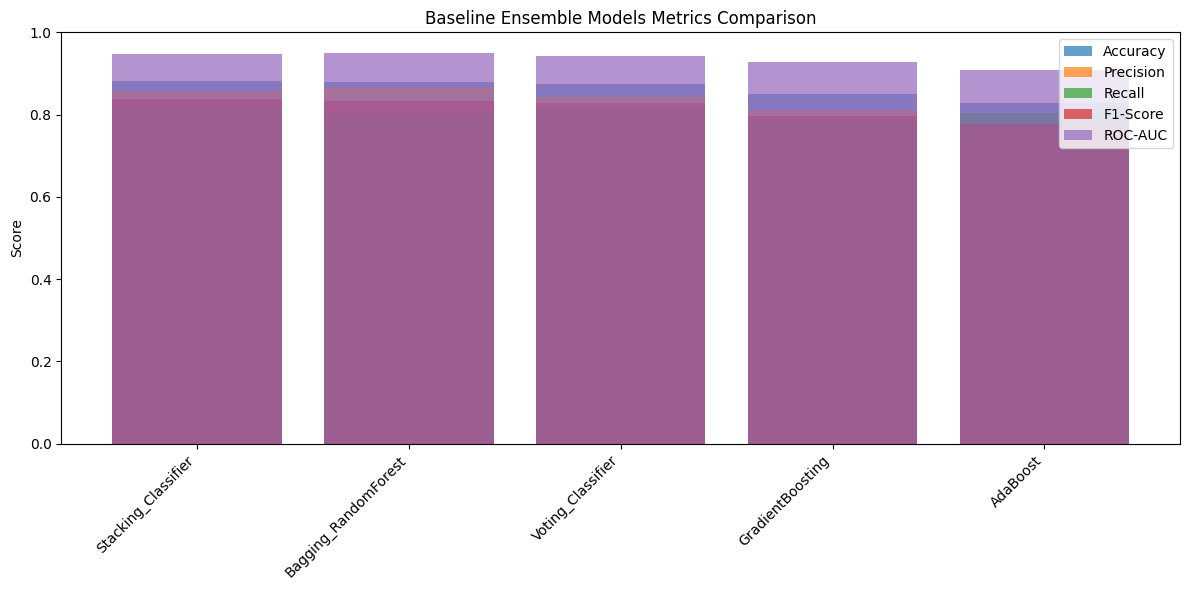

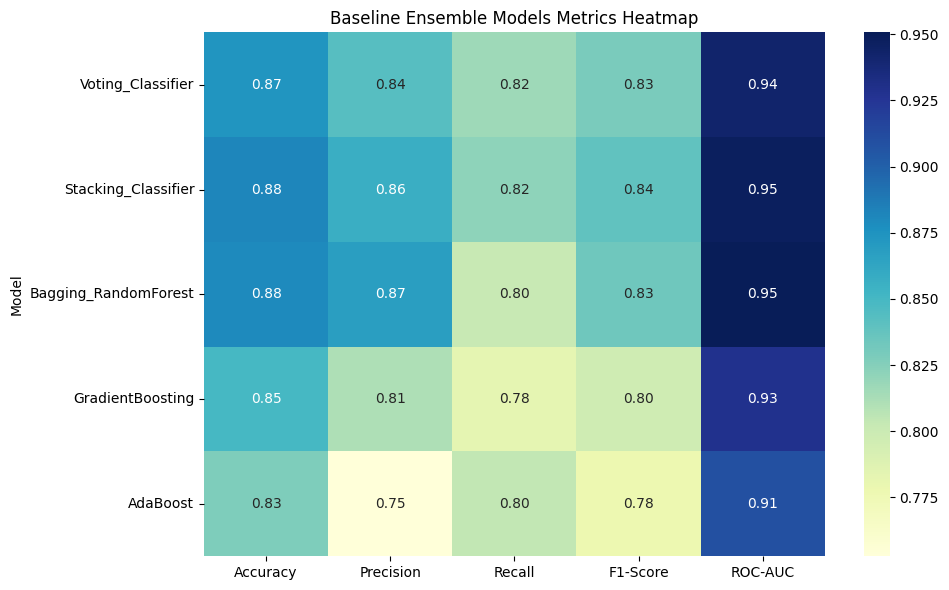

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

plt.figure(figsize=(12,6))
results_df_sorted = results_df.sort_values(by="F1-Score", ascending=False)
for metric in metrics_to_plot:
    plt.bar(results_df_sorted["Model"], results_df_sorted[metric], alpha=0.7, label=metric)

plt.title("Baseline Ensemble Models Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# HEATMAP
# =========================
plt.figure(figsize=(10,6))
sns.heatmap(results_df.set_index("Model")[metrics_to_plot], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Baseline Ensemble Models Metrics Heatmap")
plt.tight_layout()
plt.show()

In [4]:
import joblib
import os

# =========================
# SAVE PATH
# =========================
SAVE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Models\Advanced"
os.makedirs(SAVE_PATH, exist_ok=True)

# =========================
# ENG YAXSHI MODELNI TANLASH (F1 bo'yicha)
# =========================
best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

print(f"Eng yaxshi model F1 bo‘yicha: {best_model_name}")

# =========================
# MODELNI SAQLASH
# =========================
save_file = os.path.join(SAVE_PATH, f"{best_model_name}_best_model.joblib")
joblib.dump(best_model, save_file)

print(f"Model saqlandi: {save_file}")

Eng yaxshi model F1 bo‘yicha: Stacking_Classifier
Model saqlandi: C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Models\Advanced\Stacking_Classifier_best_model.joblib
